# Plotting response of and Erdos Reservoir as Spectral Radius Changes

**NOTE THIS USES THE NEW `rescomp` PACKAGE DOWNLOADABLE WITH PIP**

In [1]:
import rescomp as rc
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from scipy import sparse
from math import floor

In [2]:
RES_PARAMS = {
              "uniform_weights": True,
              "ridge_alpha": .0001,
              "signal_dim": 3,
              "res_sz": 500,
              "activ_f": np.tanh,
              "spect_rad": 50,
              "gamma": 50,
              "sigma": 1.0,
             }


def erdos(mean_degree,n=None):
    """ Erdos-Renyi random graph.
    Parameter
        mean_degree     (int): specific to this topology
        n               (int): n is the size of the network
    """
    if n is None:
        n = np.random.randint(smallest_network_size,biggest_network_size)
    p = mean_degree/n
    A = nx.adj_matrix(nx.erdos_renyi_graph(n,p)).T
    return sparse.dok_matrix(A)

def remove_edges(A, p):
    """ Randomly removes 'p' percent of edges from a sparse matrix 'A'
    """
    nedges = floor(p*np.sum(A != 0))
    A = A.todok()
    # Remove Edges
    keys = list(A.keys())
    remove_idx = np.random.choice(range(len(keys)),size=nedges, replace=False)
    remove = [keys[i] for i in remove_idx]
    for e in remove:
        A[e] = 0
    return A

def erdos_err(rho, remove_p, mean_degree, plot=False):
    n = RES_PARAMS["res_sz"]
    A = remove_edges(erdos(mean_degree, n), remove_p)
    A = sparse.lil_matrix(A)
    rcomp = rc.ResComp(A, **RES_PARAMS)
    rcomp.spect_rad = rho
    rcomp.scale_spect_rad()
    t, U = rc.orbit("lorenz", trim=True)
    r0 = np.random.rand(n)*2 - 1
    R = rcomp.internal_state_response(t, U, r0)  
    Wout = U.T @ R @ np.linalg.inv(R.T @ R)
    Uhat = (Wout@R.T).T
    if plot:
        plot_states(t, R, U, Wout, rho)
    inferr = np.max(np.abs(Uhat - U))
    l2err = np.mean(np.sum((Uhat - U)**2, axis=1)**.5)
    return inferr, l2err

def plot_states(t, R, U, Wout, rho):
    plt.plot(t - 40, R)
    end=10
    plt.title(f"$\\rho = {rho}$ ", fontsize=16)
    plt.ylim([-1.1, 1.1])
    plt.xlim([0, end + 0.1])
    plt.xticks([0])
    plt.yticks([-1, 1], fontsize=18)
    plt.xticks([0, 5, 10], fontsize=18)
    plt.xlabel("Time", fontsize=16)
    plt.ylabel("Node State", fontsize=16)
    plt.show()
    Wout = U.T @ R @ np.linalg.inv(R.T @ R)
    Uhat = (Wout@R.T).T
    #plt.plot(Uhat)
    err = np.max(np.abs(Uhat - U))
    print(f"Error {err}")

## Decoupled Reservoir Node States. Spectral Radius = 0.25

In [3]:
remove_p = 0.95
mean_degree = 4

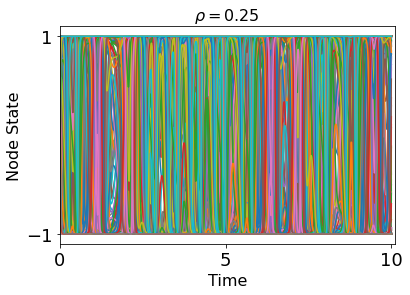

Error 443.47470698164045


(443.47470698164045, 360.8382448614196)

In [4]:
erdos_err(0.25, remove_p, mean_degree, plot=True)

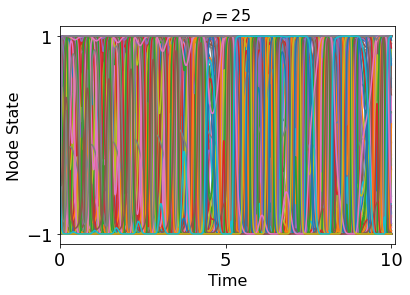

Error 516.7709581394924


(516.7709581394924, 554.7623075109437)

In [5]:
erdos_err(25, remove_p, mean_degree, plot=True)

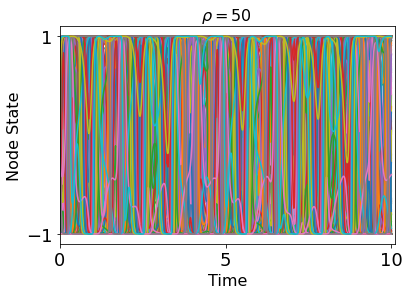

Error 589.6430489361943


(589.6430489361943, 190.17179287109366)

In [6]:
erdos_err(50, remove_p, mean_degree, plot=True)

## Decrease Connectivity

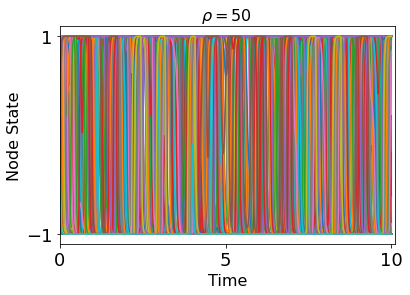

Error 467.19020772008724


(467.19020772008724, 448.47925836349106)

In [7]:
erdos_err(50, 0.0, mean_degree, plot=True)

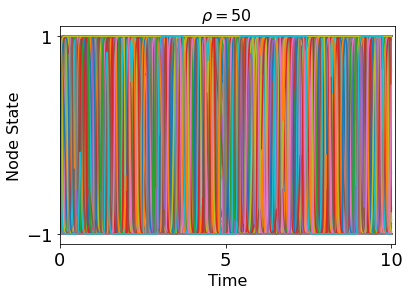

Error 261.95775649704495


(261.95775649704495, 175.14793636582462)

In [8]:
erdos_err(50, 0.5, mean_degree, plot=True)

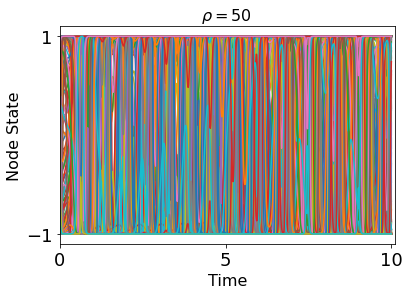

Error 522.9503025101484


(522.9503025101484, 262.9984362970047)

In [9]:
erdos_err(50, 0.9, mean_degree, plot=True)

## Spectral Radius = 50 Mean Error

In [10]:
N = 50 # Number of tests

### Remove no edges

In [11]:
rho = 50.0
remove_p = 0.0
mean_degree = 4
inferr = []
l2err = []
for i in range(N):
    inf, l2 = erdos_err(rho, remove_p, mean_degree)
    inferr.append(inf)
    l2err.append(l2)
print(f"Error: {np.mean(inferr)} (Linf) {np.mean(l2err)} (L2)")
    

Error: 2551.9594379935884 (Linf) 1989.1674932125056 (L2)


### Remove 50% of edges

In [12]:
rho = 50.0
remove_p = 0.5
mean_degree = 4
inferr = []
l2err = []
for i in range(N):
    inf, l2 = erdos_err(rho, remove_p, mean_degree)
    inferr.append(inf)
    l2err.append(l2)
print(f"Error: {np.mean(inferr)} (Linf) {np.mean(l2err)} (L2)")
    

Error: 42909.03860053686 (Linf) 37298.96680300843 (L2)


### Remove 90% of edges

In [13]:
rho = 50.0
remove_p = 0.9
mean_degree = 4
inferr = []
l2err = []
for i in range(N):
    inf, l2 = erdos_err(rho, remove_p, mean_degree)
    inferr.append(inf)
    l2err.append(l2)
print(f"Error: {np.mean(inferr)} (Linf) {np.mean(l2err)} (L2)")
    

Error: 1386.039451032172 (Linf) 1151.9266549548129 (L2)


## Connectivity = 0.7 Mean Error

### Rho = 0.25

In [14]:
rho = 0.25
remove_p = 0.7
mean_degree = 4
inferr = []
l2err = []
for i in range(N):
    inf, l2 = erdos_err(rho, remove_p, mean_degree)
    inferr.append(inf)
    l2err.append(l2)
print(f"Error: {np.mean(inferr)} (Linf) {np.mean(l2err)} (L2)")
    

Error: 860.2891018991952 (Linf) 604.5786813258549 (L2)


### Rho = 25

In [15]:
rho = 25.0
remove_p = 0.7
mean_degree = 4
inferr = []
l2err = []
for i in range(N):
    inf, l2 = erdos_err(rho, remove_p, mean_degree)
    inferr.append(inf)
    l2err.append(l2)
print(f"Error: {np.mean(inferr)} (Linf) {np.mean(l2err)} (L2)")
    

Error: 1693.4902134563206 (Linf) 1435.330955511091 (L2)


### Rho = 50

In [16]:
rho = 50.0
remove_p = 0.7
mean_degree = 4
inferr = []
l2err = []
for i in range(N):
    inf, l2 = erdos_err(rho, remove_p, mean_degree)
    inferr.append(inf)
    l2err.append(l2)
print(f"Error: {np.mean(inferr)} (Linf) {np.mean(l2err)} (L2)")
    

Error: 2302.592982882386 (Linf) 1821.4930515794438 (L2)


# Smaller Size Network

In [17]:
RES_PARAMS["res_sz"] = 50

## Low Connectivity, Increase Spectral Rad

In [32]:
remove_p = 0.7
mean_degree = 4

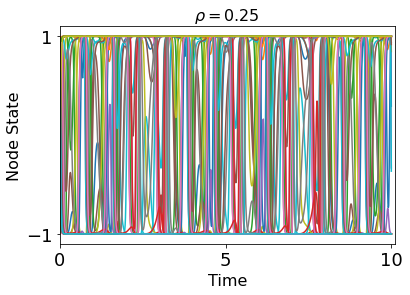

Error 47.05744535276891


(47.05744535276891, 40.36935339524545)

In [34]:
erdos_err(0.25, remove_p, mean_degree, plot=True)

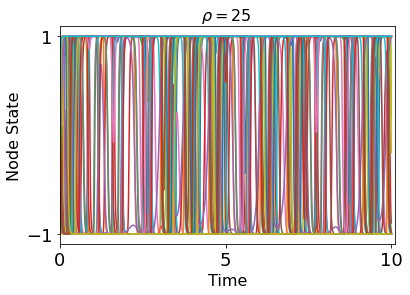

Error 6.865109100274896


(6.865109100274896, 2.5086686840300843)

In [35]:
erdos_err(25, remove_p, mean_degree, plot=True)

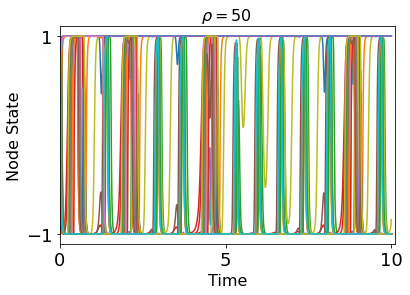

Error 69.67904272030431


(69.67904272030431, 79.82743899403778)

In [36]:
erdos_err(50, remove_p, mean_degree, plot=True)

## Decrease Connectivity

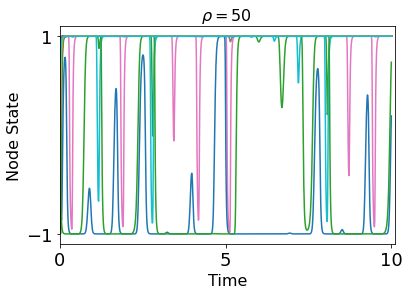

Error 179.43998236565452


(179.43998236565452, 170.167775899487)

In [37]:
erdos_err(50, 0.0, mean_degree, plot=True)

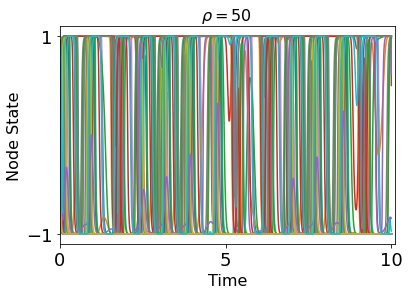

Error 229.68752943565883


(229.68752943565883, 224.27572665925229)

In [38]:
erdos_err(50, 0.5, mean_degree, plot=True)

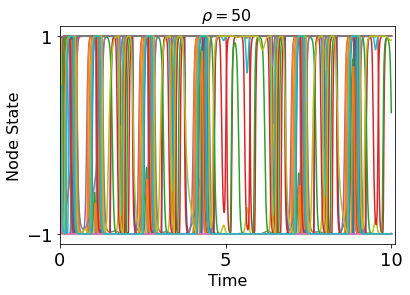

Error 221.45117209397708


(221.45117209397708, 213.8017374142725)

In [39]:
erdos_err(50, 0.7, mean_degree, plot=True)

## Spectral Radius = 50 Mean Error

### Remove no edges

In [25]:
rho = 50.0
remove_p = 0.0
mean_degree = 4
inferr = []
l2err = []
for i in range(N):
    inf, l2 = erdos_err(rho, remove_p, mean_degree)
    inferr.append(inf)
    l2err.append(l2)
print(f"Error: {np.mean(inferr)} (Linf) {np.mean(l2err)} (L2)")
    

Error: 803.5374064360212 (Linf) 752.319516155901 (L2)


### Remove 50% of edges

In [26]:
rho = 50.0
remove_p = 0.5
mean_degree = 4
inferr = []
l2err = []
for i in range(N):
    inf, l2 = erdos_err(rho, remove_p, mean_degree)
    inferr.append(inf)
    l2err.append(l2)
print(f"Error: {np.mean(inferr)} (Linf) {np.mean(l2err)} (L2)")
    

Error: 791.3381651855051 (Linf) 764.738724097754 (L2)


### Remove 80% of edges

In [27]:
rho = 50.0
remove_p = 0.8
mean_degree = 4
inferr = []
l2err = []
for i in range(N):
    inf, l2 = erdos_err(rho, remove_p, mean_degree)
    inferr.append(inf)
    l2err.append(l2)
print(f"Error: {np.mean(inferr)} (Linf) {np.mean(l2err)} (L2)")
    

Error: 574.4956135118089 (Linf) 558.5788236762137 (L2)


## Connectivity = 0.7 Mean Error

### Rho = 0.25

In [28]:
rho = 0.25
remove_p = 0.7
mean_degree = 4
inferr = []
l2err = []
for i in range(N):
    inf, l2 = erdos_err(rho, remove_p, mean_degree)
    inferr.append(inf)
    l2err.append(l2)
print(f"Error: {np.mean(inferr)} (Linf) {np.mean(l2err)} (L2)")
    

Error: 384.01546414167717 (Linf) 382.7107217613567 (L2)


### Rho = 25

In [29]:
rho = 25
remove_p = 0.7
mean_degree = 4
inferr = []
l2err = []
for i in range(N):
    inf, l2 = erdos_err(rho, remove_p, mean_degree)
    inferr.append(inf)
    l2err.append(l2)
print(f"Error: {np.mean(inferr)} (Linf) {np.mean(l2err)} (L2)")
    

Error: 446.0968156171991 (Linf) 419.1171746670087 (L2)


### Rho = 50

In [30]:
rho = 50
remove_p = 0.7
mean_degree = 4
inferr = []
l2err = []
for i in range(N):
    inf, l2 = erdos_err(rho, remove_p, mean_degree)
    inferr.append(inf)
    l2err.append(l2)
print(f"Error: {np.mean(inferr)} (Linf) {np.mean(l2err)} (L2)")
    

Error: 1346.4038802432458 (Linf) 1299.7447355069512 (L2)
